![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/ocr/DEID_DICOM_IMAGE.ipynb)

# **Deidentify DICOM Images**
Deidentify text and metada

To run this yourself, you will need to upload your **Spark OCR & Sprk NLP** license keys to the notebook. Otherwise, you can look at the example outputs at the bottom of the notebook. To upload license keys, open the file explorer on the left side of the screen and upload `workshop_license_keys.json` to the folder that opens.

# 1. Colab Setup

Install correct version of Pillow and Restart runtime

In [1]:
# Install correct Pillow version
import PIL
if PIL.__version__  != '6.2.1':
  print ('Installing correct version of Pillow. Kernel will restart automatically')
  !pip install --upgrade pillow==6.2.1
  # hard restart runtime
  import os
  os.kill(os.getpid(), 9)
else:
  print ('Correct Pillow detected')

Correct Pillow detected


Read License Key

In [3]:
import os
import json

with open('workshop_license_keys.json') as f:
    license_keys = json.load(f)

secret = license_keys['JSL_OCR_SECRET']
jsl_secret = license_keys['JSL_SECRET']
os.environ['SPARK_OCR_LICENSE'] = license_keys['SPARK_OCR_LICENSE']
os.environ['JSL_OCR_LICENSE'] = license_keys['SPARK_OCR_LICENSE']
os.environ['AWS_ACCESS_KEY_ID']= license_keys['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY'] = license_keys['AWS_SECRET_ACCESS_KEY']
version = secret.split("-")[0]
jsl_version = jsl_secret.split('-')[0]
print ('Spark OCR Version:', version)
print ('OCR Version:', version,)
print ('JSL Version:', jsl_version)

Spark OCR Version: 1.5.0
OCR Version: 1.5.0
JSL Version: 2.5.5


Install Dependencies

In [ ]:
# Install Java
!apt-get update
!apt-get install -y openjdk-8-jdk
!java -version

# Install pyspark
!pip install --ignore-installed -q pyspark==2.4.4
# Install Spark OCR from PYPI using secret
!python -m pip install --upgrade spark-ocr==$version  --extra-index-url https://pypi.johnsnowlabs.com/$secret

# Install Spark NLP and Spark NLP JSL
! pip install --ignore-installed -q spark-nlp
!python -m pip install --upgrade spark-nlp-jsl==$jsl_version --extra-index-url https://pypi.johnsnowlabs.com/$jsl_secret


Importing Libraries

In [5]:
import pandas as pd
import numpy as np
import os

#Pyspark Imports
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

# Necessary imports from Spark OCR library
from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image, to_pil_image
from sparkocr.metrics import score
import pkg_resources

# import sparknlp packages
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]


Start Spark Session

In [6]:
spark = start(secret=secret,
              nlp_secret=jsl_secret,
              nlp_version=jsl_version,
              nlp_internal=True)

spark

# 2. Download and read DICOM Image

Download Image

In [22]:
!wget https://github.com/JohnSnowLabs/spark-ocr-workshop/raw/master/jupyter/data/dicom/deidentify-brains-front-medical-3.dcm -O image.dcm

--2020-08-19 18:34:25--  https://github.com/JohnSnowLabs/spark-ocr-workshop/raw/master/jupyter/data/dicom/deidentify-brains-front-medical-3.dcm
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/dicom/deidentify-brains-front-medical-3.dcm [following]
--2020-08-19 18:34:26--  https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/dicom/deidentify-brains-front-medical-3.dcm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3836142 (3.7M) [application/octet-stream]
Saving to: ‘image.dcm’

image.dcm           100%[=============

In [23]:
image_df = spark.read.format("binaryFile").load('image.dcm').cache()
image_df.show()

+--------------------+-------------------+-------+--------------------+
|                path|   modificationTime| length|             content|
+--------------------+-------------------+-------+--------------------+
|file:/content/ima...|2020-08-19 18:34:27|3836142|[02 00 01 00 4F 4...|
+--------------------+-------------------+-------+--------------------+



Read Image and metadata

Image:
        origin: file:/content/image.dcm 
        width: 1520
        height: 841
        mode: 10


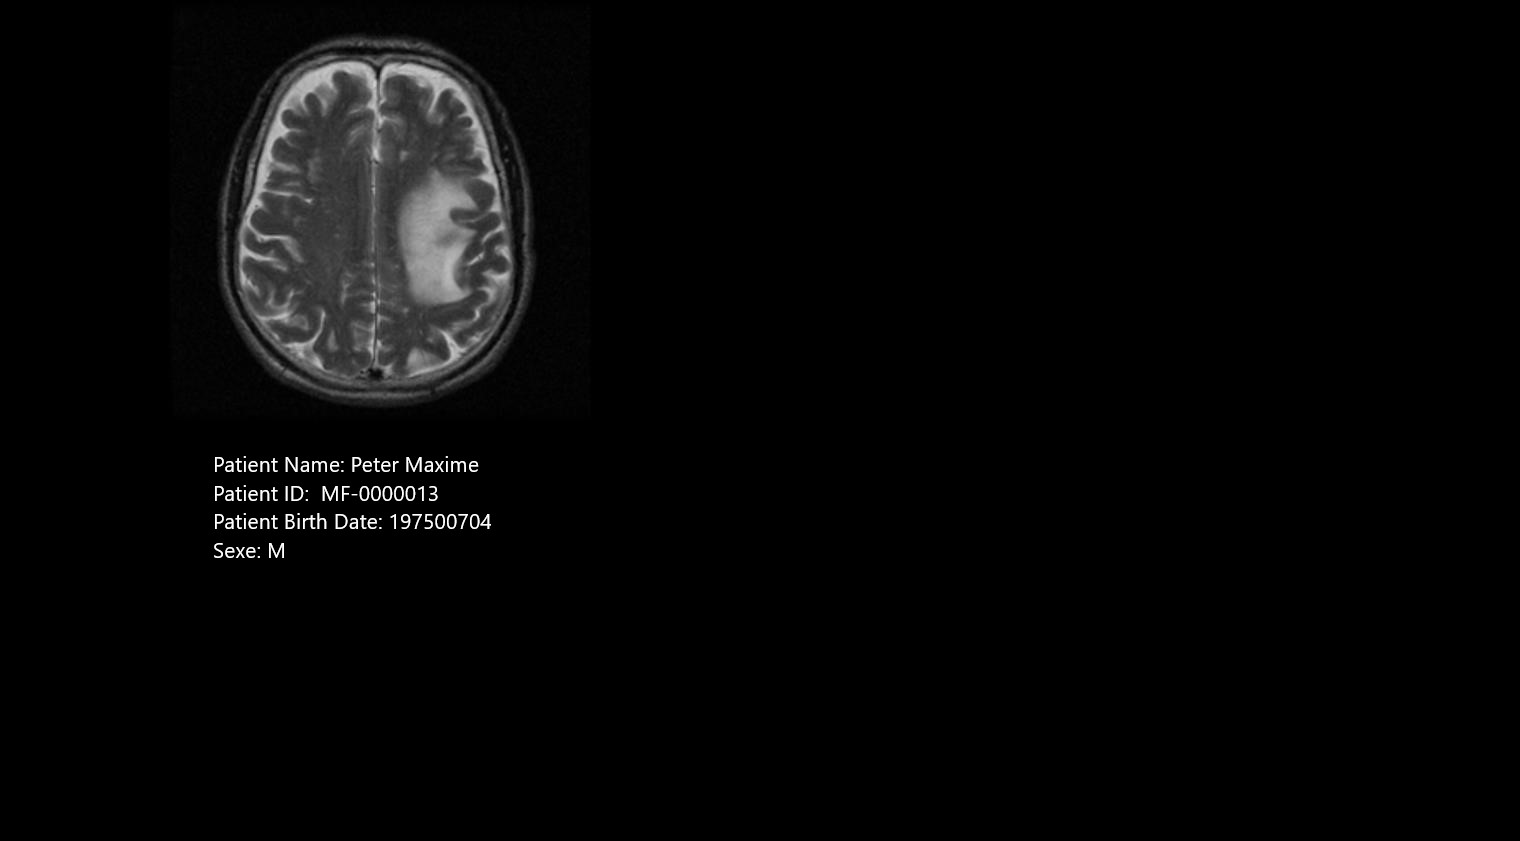

Image:
        origin: file:/content/image.dcm 
        width: 1520
        height: 841
        mode: 10


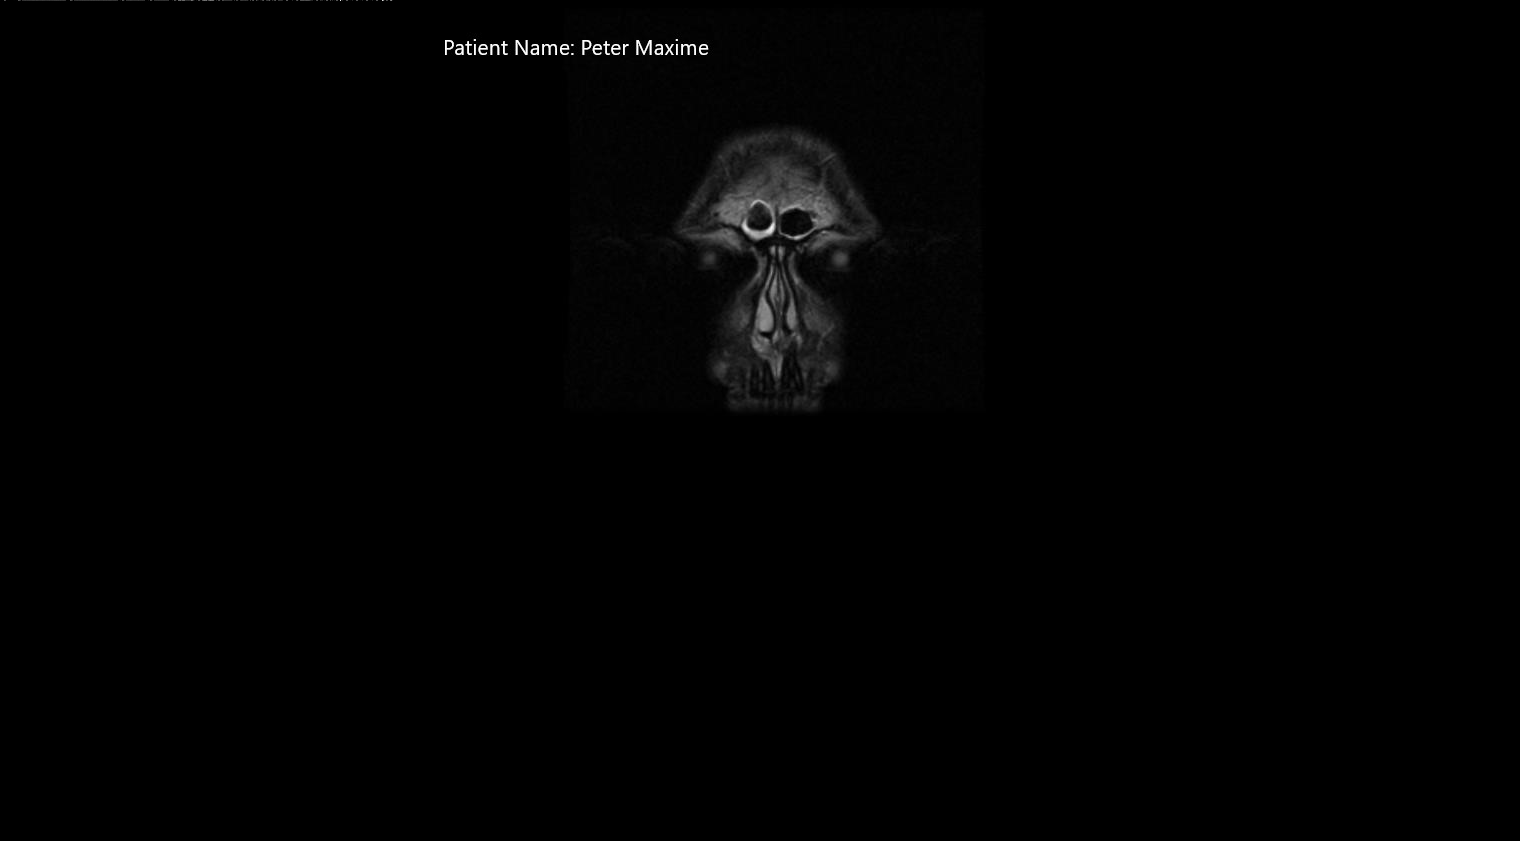

Image:
        origin: file:/content/image.dcm 
        width: 1520
        height: 841
        mode: 10


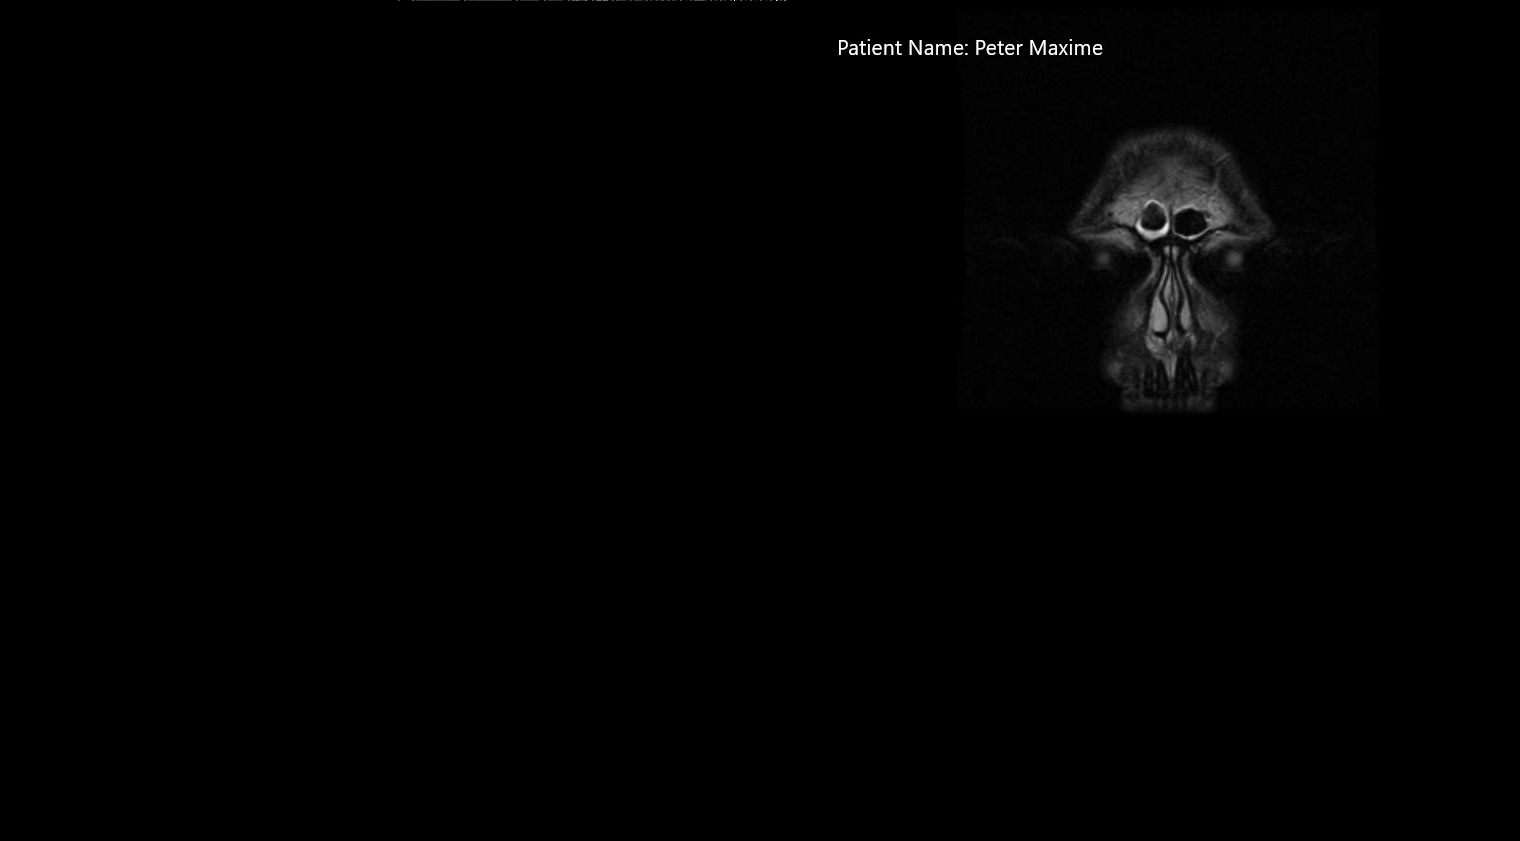

In [24]:
for image in DicomToImage().transform(image_df).collect():
  #print(image.exception)
  #print(image.metadata)
  display_image(image.image)

# 3. Construct OCR and DEID (NLP) Pipelines

Deidentification Pipeline

In [25]:
def deidentification_nlp_pipeline(input_column, prefix = ""):
    document_assembler = DocumentAssembler() \
        .setInputCol(input_column) \
        .setOutputCol(prefix + "document")

    # Sentence Detector annotator, processes various sentences per line
    sentence_detector = SentenceDetector() \
        .setInputCols([prefix + "document"]) \
        .setOutputCol(prefix + "sentence")

    tokenizer = Tokenizer() \
        .setInputCols([prefix + "sentence"]) \
        .setOutputCol(prefix + "token")

    # Clinical word embeddings
    word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token"]) \
        .setOutputCol(prefix + "embeddings")
    # NER model trained on i2b2 (sampled from MIMIC) dataset
    clinical_ner = NerDLModel.pretrained("ner_deid_large", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "embeddings"]) \
        .setOutputCol(prefix + "ner")

    custom_ner_converter = NerConverter() \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "ner"]) \
        .setOutputCol(prefix + "ner_chunk") \
        .setWhiteList(['NAME', 'AGE', 'CONTACT',
                   'LOCATION', 'PROFESSION', 'PERSON']) #You can set the whitelist accordingly

    nlp_pipeline = Pipeline(stages=[
            document_assembler,
            sentence_detector,
            tokenizer,
            word_embeddings,
            clinical_ner,
            custom_ner_converter
        ])
    empty_data = spark.createDataFrame([[""]]).toDF(input_column)
    nlp_model = nlp_pipeline.fit(empty_data)
    return nlp_model

OCR and Metadata Deidentification.

In [26]:
# Extract jpg images from Dicom images
# Set deidentify metadata to True
dicom_to_image = DicomToImage() \
    .setInputCol("content") \
    .setOutputCol("image_raw") \
    .setMetadataCol("metadata") \
    .setDeIdentifyMetadata(True)

# Extract text from image
ocr = ImageToText() \
    .setInputCol("image_raw") \
    .setOutputCol("text") \
    .setIgnoreResolution(False) \
    .setOcrParams(["preserve_interword_spaces=0"])


# Found sensitive data using DeIdentificationModel
deidentification_rules = DeIdentificationModel.pretrained("deidentify_rb_no_regex", "en", "clinical/models") \
    .setInputCols(["metadata_sentence", "metadata_token","metadata_ner_chunk"]) \
    .setOutputCol("deidentified_metadata_raw")

finisher = Finisher() \
    .setInputCols(["deidentified_metadata_raw"]) \
    .setOutputCols("deidentified_metadata") \
    .setOutputAsArray(False) \
    .setValueSplitSymbol("") \
    .setAnnotationSplitSymbol("")


# Found coordinates of sensitive data
position_finder = PositionFinder() \
    .setInputCols("ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setMatchingWindow(10) \
    .setPadding(0)

# Draw filled rectangle for hide sensitive data
drawRegions = ImageDrawRegions()  \
    .setInputCol("image_raw")  \
    .setInputRegionsCol("coordinates")  \
    .setOutputCol("image_with_regions")  \
    .setFilledRect(True)

# Store image back to Dicom document
imageToDicom = ImageToDicom() \
    .setInputCol("image_with_regions") \
    .setOutputCol("dicom") \
    .setInputMetadata("deidentified_metadata")

# OCR pipeline
pipeline = Pipeline(stages=[
    dicom_to_image,
    ocr,
    deidentification_nlp_pipeline(input_column="text"),
    deidentification_nlp_pipeline(input_column="metadata", prefix="metadata_"),
    deidentification_rules,
    position_finder,
    drawRegions,
    finisher,
    imageToDicom
])

deidentify_rb_no_regex download started this may take some time.
Approximate size to download 8.9 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_large download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_large download started this may take some time.
Approximate size to download 13.9 MB
[OK!]


# 4. Run the pipelines and save Deidentified Dicom Image

In [27]:
de_dicom_df = pipeline.fit(image_df).transform(image_df).cache()

output_path = "./"

for r in de_dicom_df.select("dicom", "path").collect():
    path, name = os.path.split(r.path)
    filename_split = os.path.splitext(name)
    file_name = os.path.join(output_path, filename_split[0]+".dcm")
    print(f"Storing to {file_name}")
    with open(file_name, "wb") as file:
        file.write(r.dicom)

Storing to ./image.dcm


# 5. Load Deidentified Dicom Images and Visualize Results

Image:
        origin: file:/content/image.dcm 
        width: 1520
        height: 841
        mode: 10


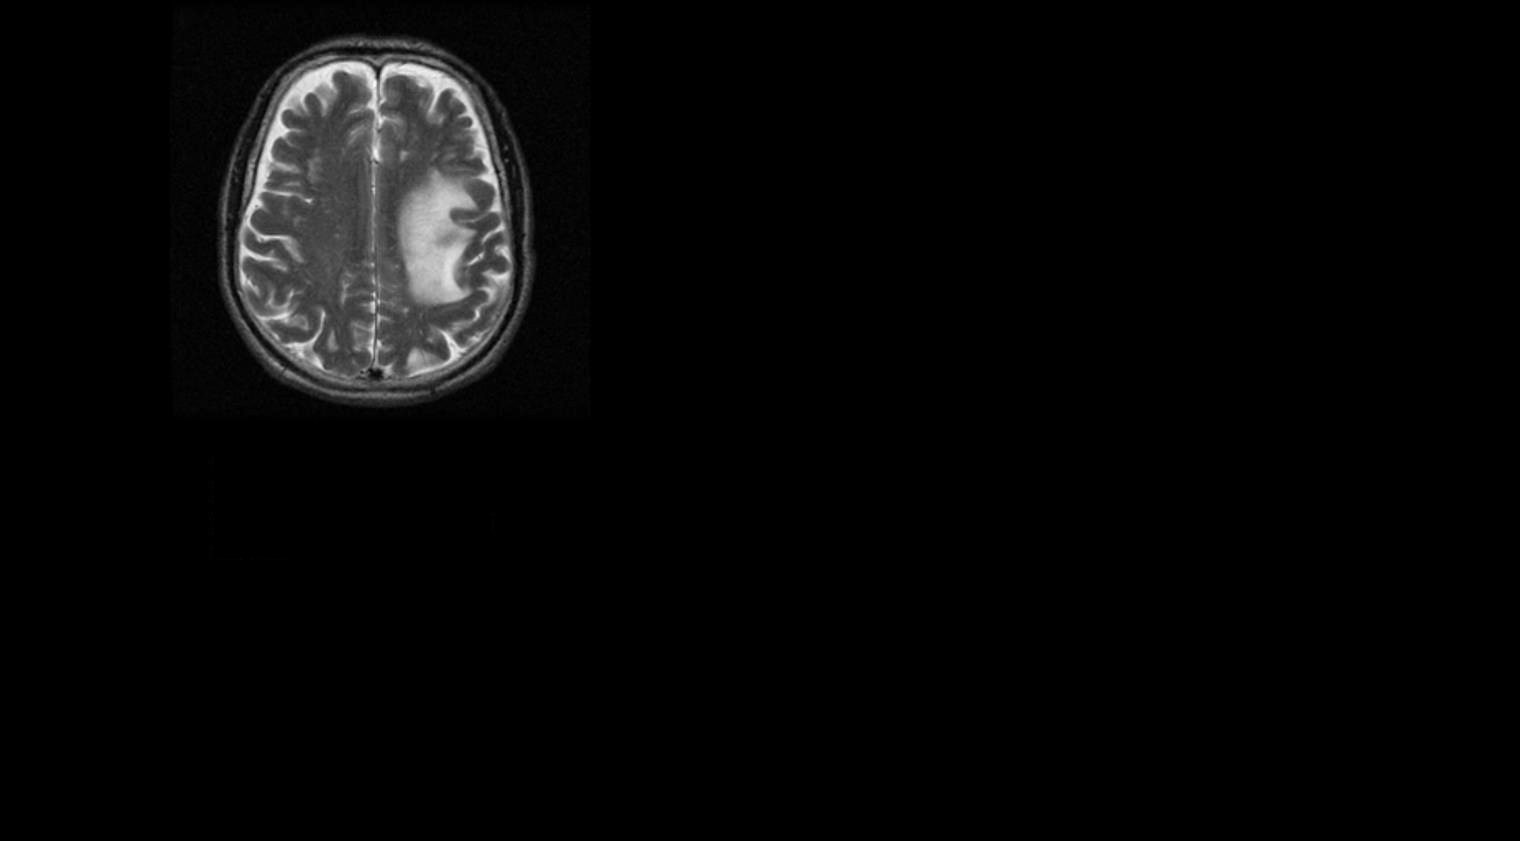


{
    "00020001": {
        "vr": "OB",
        "InlineBinary": "AAE="
    },
    "00020002": {
        "vr": "UI",
        "Value": [
            "2.25.132306736029470667028236019366994122946"
        ]
    },
    "00020003": {
        "vr": "UI",
        "Value": [
            "2.25.252688478945126142399266486554944219611"
        ]
    },
    "00020010": {
        "vr": "UI",
        "Value": [
            "1.2.840.10008.1.2.1"
        ]
    },
    "00020012": {
        "vr": "UI",
        "Value": [
            "1.2.40.0.13.1.3"
        ]
    },
    "00020013": {
        "vr": "SH",
        "Value": [
            "dcm4che-1.5.0"
        ]
    },
    "00100010": {
        "vr": "PN"
    },
    "00100020": {
        "vr": "LO"
    },
    "00100030": {
        "vr": "DA"
    },
    "00100040": {
        "vr": "CS"
    },
    "00120062": {
        "vr": "CS",
        "Value": [
            "YES"
        ]
    },
    "00120064": {
        "vr": "SQ",
        "Value": [
            {
  

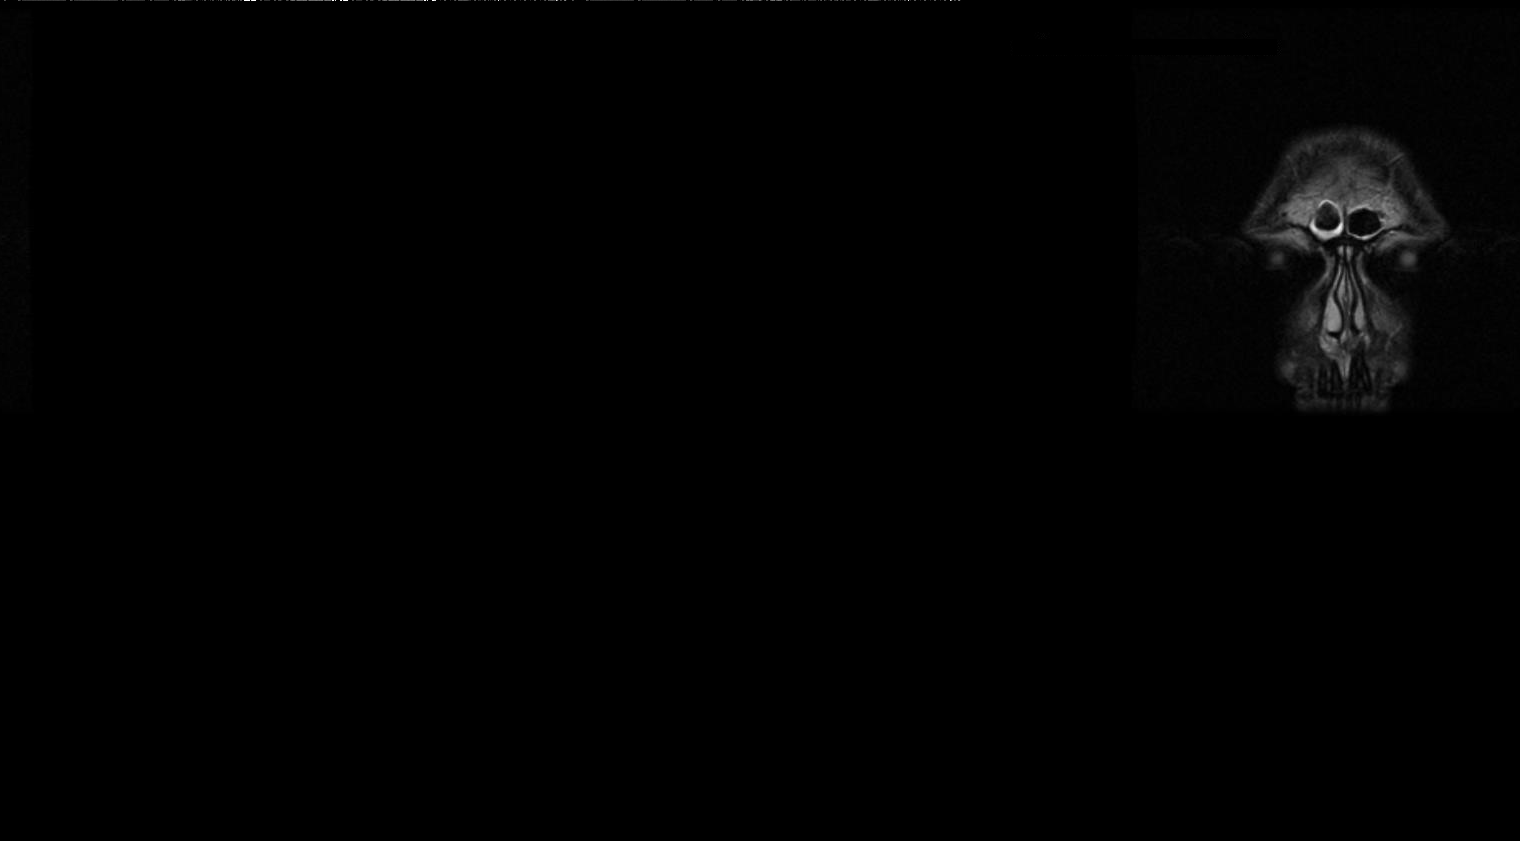


{
    "00020001": {
        "vr": "OB",
        "InlineBinary": "AAE="
    },
    "00020002": {
        "vr": "UI",
        "Value": [
            "2.25.132306736029470667028236019366994122946"
        ]
    },
    "00020003": {
        "vr": "UI",
        "Value": [
            "2.25.252688478945126142399266486554944219611"
        ]
    },
    "00020010": {
        "vr": "UI",
        "Value": [
            "1.2.840.10008.1.2.1"
        ]
    },
    "00020012": {
        "vr": "UI",
        "Value": [
            "1.2.40.0.13.1.3"
        ]
    },
    "00020013": {
        "vr": "SH",
        "Value": [
            "dcm4che-1.5.0"
        ]
    },
    "00100010": {
        "vr": "PN"
    },
    "00100020": {
        "vr": "LO"
    },
    "00100030": {
        "vr": "DA"
    },
    "00100040": {
        "vr": "CS"
    },
    "00120062": {
        "vr": "CS",
        "Value": [
            "YES"
        ]
    },
    "00120064": {
        "vr": "SQ",
        "Value": [
            {
  

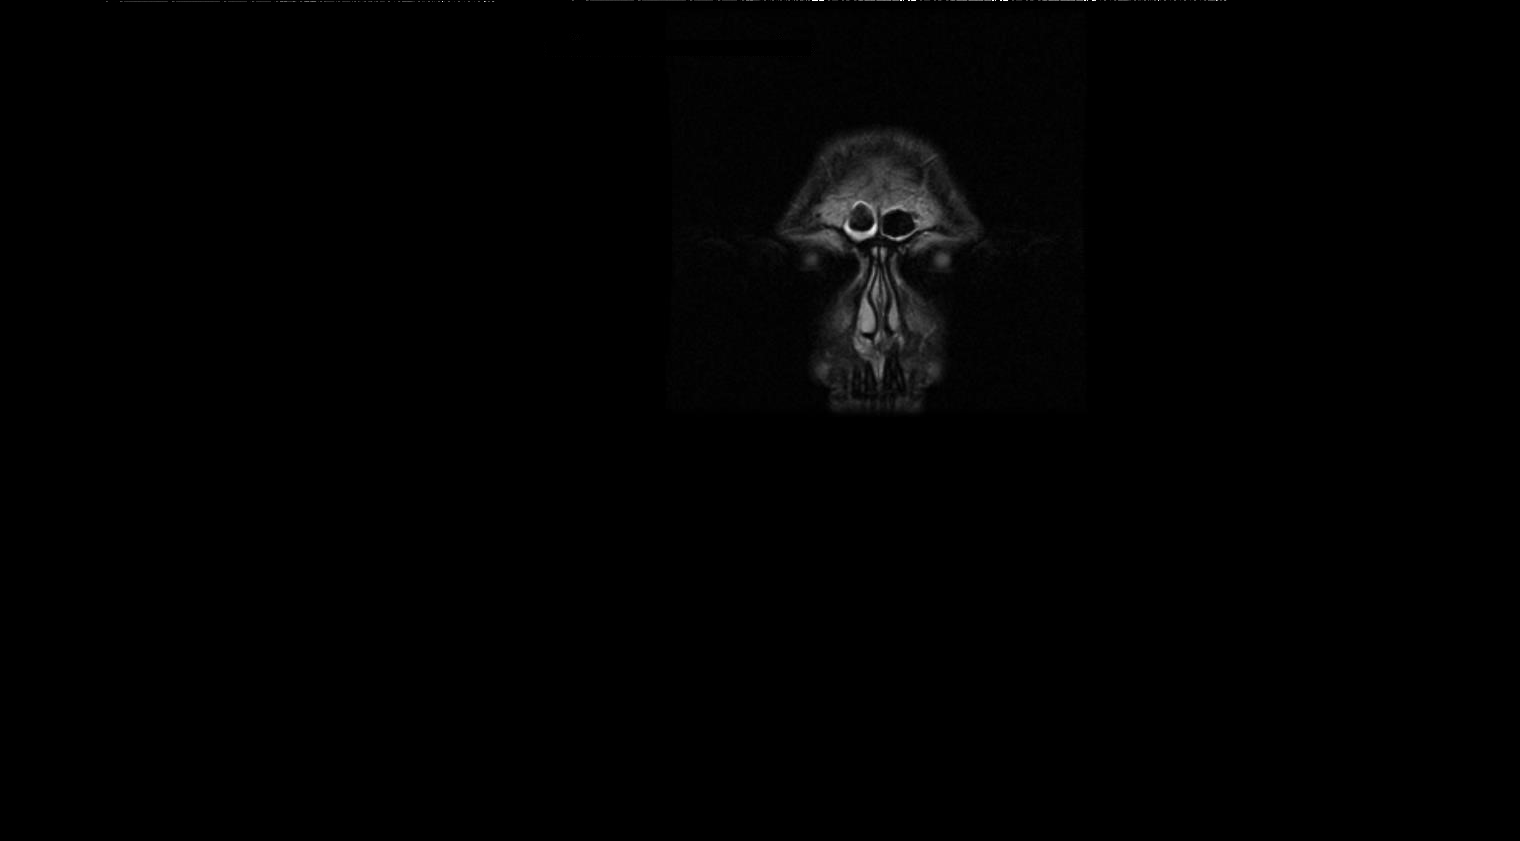


{
    "00020001": {
        "vr": "OB",
        "InlineBinary": "AAE="
    },
    "00020002": {
        "vr": "UI",
        "Value": [
            "2.25.132306736029470667028236019366994122946"
        ]
    },
    "00020003": {
        "vr": "UI",
        "Value": [
            "2.25.252688478945126142399266486554944219611"
        ]
    },
    "00020010": {
        "vr": "UI",
        "Value": [
            "1.2.840.10008.1.2.1"
        ]
    },
    "00020012": {
        "vr": "UI",
        "Value": [
            "1.2.40.0.13.1.3"
        ]
    },
    "00020013": {
        "vr": "SH",
        "Value": [
            "dcm4che-1.5.0"
        ]
    },
    "00100010": {
        "vr": "PN"
    },
    "00100020": {
        "vr": "LO"
    },
    "00100030": {
        "vr": "DA"
    },
    "00100040": {
        "vr": "CS"
    },
    "00120062": {
        "vr": "CS",
        "Value": [
            "YES"
        ]
    },
    "00120064": {
        "vr": "SQ",
        "Value": [
            {
  

In [29]:
dicom_gen_df = spark.read.format("binaryFile").load("./*.dcm")
de_dicom_gen_df = DicomToImage().transform(dicom_gen_df)
for r in de_dicom_gen_df.select("image", "metadata").collect():
    display_image(r.image)
    print(r.metadata)